In [1]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
from config import configuration
config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [2]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    v = pickle.load(f)

Text(0, 0.5, 'phi1-2phi0')

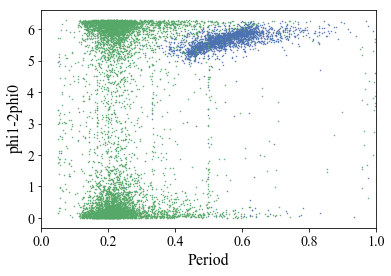

In [3]:
plt.plot(v['lsq_period'][(v['var_class']=='RRab')&(v['ks_n_detections']>500)],
         (v['phi_1']-2*v['phi_0'])[(v['var_class']=='RRab')&(v['ks_n_detections']>500)]%(2.*np.pi),'.',ms=1);

plt.plot(v['lsq_period'][(v['var_class']=='EW')&(v['ks_n_detections']>500)],
         (v['phi_1']-2*v['phi_0'])[(v['var_class']=='EW')&(v['ks_n_detections']>500)]%(2.*np.pi),'.',ms=1);

plt.xlim(0.,1.)
plt.xlabel('Period')
plt.ylabel('phi1-2phi0')

## Perhaps we use at least 4 terms and then compare with results using more terms??

In [5]:
from lc_utils import *

[0.3667406]
nterms 10
0.27553448
0.01274328942640396


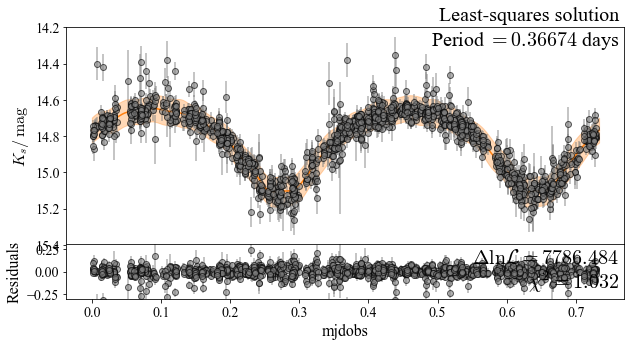

In [6]:
ii=5
sid,period=v[['sourceid']][(v['var_class']=='EW')&(v['ks_n_detections']>1000)].values[ii],v[['ls_period']][(v['var_class']=='EW')&(v['ks_n_detections']>1000)].values[ii]
import sqlutilpy as sqlutil
ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
print(period)
import sys
sys.path.append('../../../../variability/')
from lc_utils import fourier_poly_chi2_fit_full, plot_lc_LSQ
lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,500000,1)
lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,.5/lsc['lsq_period'],2./lsc['lsq_period'],4,
                                                 1,10,
                              regularization=1e-4)
print('nterms',lsc['lsq_nterms'])
# print('chi2',lsc['chi2_ref'])
plot_lc_LSQ(ss, lsc, fold=True);
print(find_peak_ratio(ss,lsc))
print(find_peak_ratio_model(ss,lsc))
# lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,.5/lsc['lsq_period'],2./lsc['lsq_period'],4,10,
#                               regularization=1e-4,regularize_by_trace=True)
# print('chi2',lsc['chi2_ref'])

# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# # lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,1./(lsc['lsq_period']*2.),1./(lsc['lsq_period']*2.)*1.01,10000,3)
# plot_lc_LSQ(ss, lsc, fold=True);
# ss2 = ss.copy()
# ss2['mjdobs']+=lsc['phases'][0]*lsc['lsq_period']/(2.*np.pi)
# lsc2=fourier_poly_chi2_fit_full_quick(ss2,nterms=4,minp=0.1,maxp=10.)
# plot_lc_LSQ(ss2, lsc2, fold=True);
# print(lsc['amplitudes'])
# print(lsc2['fourier_coeffs'])

## To do

1. Make the period multiple checks more robust -- perhaps write a new function
3. Lower the regularization used in the period finding
4. How do we get the plot in Jayasinghe??

1908


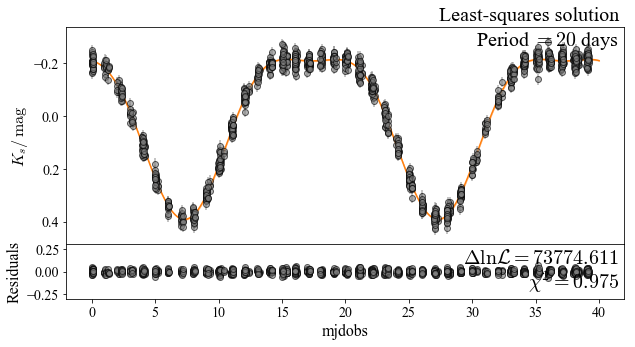

In [175]:
fake = ss.copy()
np.random.seed(42)
# fake = fake[:8].reset_index(drop=True)
fake['mjdobs']+=9.
fake['error']=0.02
fake['mag'] = 0.09*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/10.)+\
                0.3*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/20.)+\
                0.*np.cos(2.*np.pi*(fake['mjdobs']-fake['mjdobs'][0])/5.)+np.random.normal(0., fake['error'], len(fake['error']))
MINP = 5.
MAXP = 20.
from lc_utils import autofrequency
NGRID = len(
            autofrequency(fake['mjdobs'].values,
                          maximum_frequency=1. / MINP,
                          minimum_frequency=1. / MAXP)) // 2 * 2
print(NGRID)
lsc_test=fourier_poly_chi2_fit_full_nterms_iterations(fake['mjdobs'].values,
                                                      fake['mag'].values,
                                                      fake['error'].values,1./MAXP,1./MINP,NGRID,
                                                      1,4,regularization=1e-4)
times = np.linspace(0.,lsc_test['lsq_period'],100)
ffp = retrieve_fourier_poly(times,lsc_test,with_var=True)
# print(lsc_test['fourier_coeffs_cov'])
plot_lc_LSQ(fake, lsc_test, fold=True);
# plt.figure()
# print(lsc_test['amplitudes'])
# from lc_utils import find_peak_ratio
# plt.plot(((fake['mjdobs']-7.187187187187187) / ( lsc_test['lsq_period'] ))% 1, 
#          fake['mag'], '.')
# plt.gca().invert_yaxis()
# print(find_peak_ratio(fake, lsc_test))
# print(find_peak_ratio_model(fake, lsc_test))

In [176]:
print(check_significant_second_minimum(fake, lsc_test,[0.2,0.8]))

True


In [1438]:
from lc_utils import find_peak_ratio_model, string_length_grid
import time

In [1440]:
# %%timeit -n 1 -r 1
SS = string_length_grid(ss['mjdobs'].values, ss['mag'].values, 0.1,10.,50000)
print(SS[0][np.argmin(SS[1])])

6.104860064642086


In [141]:
from lc_utils import check_second_minimum, check_second_maximum, check_second_minimum_depth
import sys
sys.path.append('../../../../variability/')
from lc_utils import fourier_poly_chi2_fit_full_nterms_iterations, plot_lc_LSQ

In [1845]:
import sqlutilpy as sqlutil

def find_period_check_minimum(ii, with_plot=False, show_data=False, typee = 'EA/EB', phase_range=[0.35,0.65], show_plot=False):
    sid,period,cat_period=v[['sourceid']][(v['var_class']==typee)&(v['ks_n_detections']>1000)].values[ii],\
            v[['ls_period']][(v['var_class']==typee)&(v['ks_n_detections']>1000)].values[ii],\
            v[['cat_period']][(v['var_class']==typee)&(v['ks_n_detections']>1000)].values[ii]
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<13.)&(ss['amb']==0)].reset_index(drop=True)
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,
                                                     4,10,regularization=optimum_regularization(ss),
                                                     use_nfft=False,
                                                    )
    
#     return lsc['lsq_period'], cat_period, check_significant_second_minimum(ss, lsc, noise_thresh_factor=5, phase_range=phase_range, show_plot=show_plot)
    
    if ~check_significant_second_minimum(ss, lsc, noise_thresh_factor=5, phase_range=phase_range, show_plot=show_plot):
        lsc_t = fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],0.5000001/lsc['lsq_period'],
                                                     4,4,10,regularization=optimum_regularization(ss),
                                                     use_nfft=False,check_multiples=False
                                                    )
    else:
        lsc_t=lsc
    if(with_plot):
        plot_lc_LSQ(ss, lsc, fold=True, show_data=show_data)
        
    return lsc['lsq_period'], cat_period, \
            check_significant_second_minimum(ss, lsc, noise_thresh_factor=5, phase_range=phase_range, show_plot=show_plot),\
            lsc_t['amplitudes'][:4], find_peak_ratio(ss, lsc), find_peak_ratio_model(ss, lsc)

In [1857]:
from functools import partial
pl = Pool(16)
pp = pl.map(partial(find_period_check_minimum, typee='EA/EB'), np.arange(200))
pl.close()
pl.join()
out_period = np.array([pl[0] for pl in pp])
cat_period = np.array([pl[1][0] for pl in pp])
second_min = np.array([pl[2] for pl in pp])

In [1858]:
from functools import partial
pl = Pool(16)
pp_EW = pl.map(partial(find_period_check_minimum, typee='EW'), np.arange(200))
pl.close()
pl.join()
out_period_EW = np.array([pl[0] for pl in pp_EW])
cat_period_EW = np.array([pl[1][0] for pl in pp_EW])
second_min_EW = np.array([pl[2] for pl in pp_EW])

[]

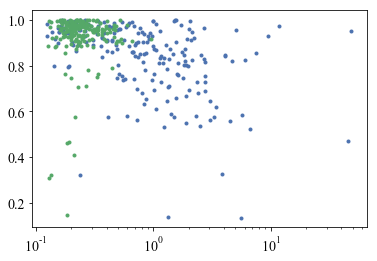

In [1859]:
plt.plot(out_period, np.array([pl[4] for pl in pp]),'.')
plt.semilogx()
plt.plot(out_period_EW, np.array([pl[4] for pl in pp_EW]),'.')
plt.semilogx()
# plt.ylim(0.5,1.)

(0.0, 0.3)

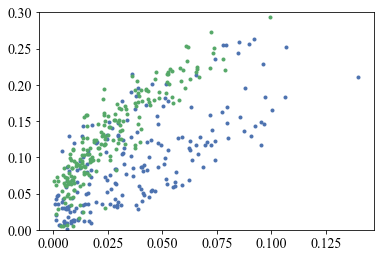

In [1860]:
plt.plot(np.array([pl[3][3] for pl in pp]), np.array([pl[3][1] for pl in pp]),'.')

plt.plot(np.array([pl[3][3] for pl in pp_EW]), np.array([pl[3][1] for pl in pp_EW]),'.')

# plt.plot(out_period_EW, np.array([pl[3][1]/pl[3][3]  for pl in pp_EW]),'.')
# plt.semilogx()
plt.ylim(0.,0.3)

In [738]:
np.argwhere((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW)).flatten(),\
np.argwhere((np.abs((out_period_EW*2.-cat_period_EW)/cat_period_EW)<0.1)&(second_min_EW)).flatten()

(array([], dtype=int64), array([ 34,  66, 109, 118, 142, 165]))

[]

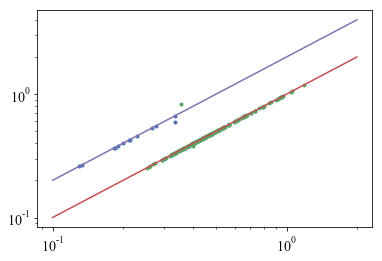

In [1861]:
plt.plot(out_period_EW[second_min_EW], cat_period_EW[second_min_EW], '.', label='Period good')
plt.plot(2.*out_period_EW[~second_min_EW], cat_period_EW[~second_min_EW], '.', label='Cat period is double')
xx = np.linspace(0.1,2.)
plt.plot(xx,xx)
plt.plot(xx,2.*xx)
plt.semilogy()
plt.semilogx()

In [1993]:
np.argwhere(~(((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))|((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW))))

array([[ 16],
       [ 34],
       [101],
       [109],
       [113],
       [118],
       [126],
       [129],
       [131],
       [142],
       [156],
       [165],
       [176],
       [199]])

In [1864]:
np.count_nonzero((np.abs((out_period_EW-cat_period_EW)/cat_period_EW)<0.1)\
                    &(second_min_EW))+np.count_nonzero((np.abs((2.*out_period_EW-cat_period_EW)/cat_period_EW)<0.1)&(~second_min_EW))

186

In [1865]:
np.count_nonzero((np.abs((out_period-cat_period)/cat_period)<0.1)\
                    &(second_min))+np.count_nonzero((np.abs((2.*out_period-cat_period)/cat_period)<0.1)&(~second_min))

167

[]

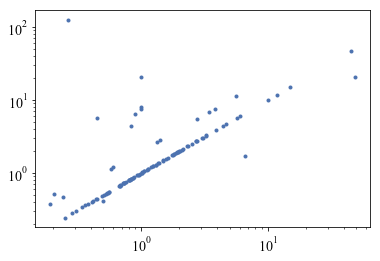

In [1001]:
plt.plot(out_period[second_min], cat_period[second_min], '.')
# plt.plot(2.*out_period[~second_min], cat_period[~second_min], '.')

plt.semilogy()
plt.semilogx()

In [977]:
np.argwhere((np.abs((out_period-cat_period)/cat_period)>0.1)&(second_min))

array([], shape=(0, 1), dtype=int64)

In [739]:
np.argwhere((np.abs((out_period-cat_period)/cat_period)<0.1)&(~second_min)).flatten(),\
np.argwhere((np.abs((out_period*2.-cat_period)/cat_period)<0.1)&(second_min)).flatten()

(array([91]), array([ 18,  35, 103, 123, 137, 150, 162, 183, 191]))

In [1064]:
lsc['lsq_chi_squared']

1469.8670117243869

(0.1300414191569809,
 array([0.2600828]),
 True,
 array([0.30209395, 0.11763596, 0.05230408, 0.02156872]),
 0.30769002,
 0.04074300546596808)

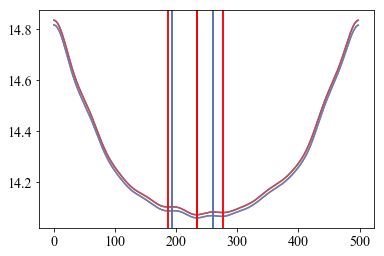

In [1063]:
find_period_check_minimum(34, False, False, typee='EW', phase_range=[0.35,0.65], show_plot=True)
# plt.figure()
# find_period_check_minimum(43, False, False, typee='EW', phase_range=[0.35,0.65], show_plot=True)

In [358]:
np.count_nonzero(second_min)

352

In [354]:
np.count_nonzero((np.abs((out_period-cat_period)/cat_period)<0.1)&(~second_min)),\
np.count_nonzero((np.abs((out_period*2.-cat_period)/cat_period)<0.1)&(second_min))

(3, 55)

In [450]:
import ellc

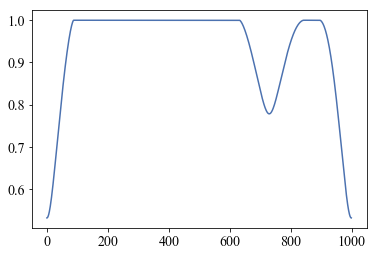

In [537]:
e = 0
plt.plot(ellc.lc(np.linspace(0.,1.,1000),0.3,0.3,0.5,80.,f_c=0.6,f_s=0.1))

(0.5371401900068609, array([0.53714839]), False)

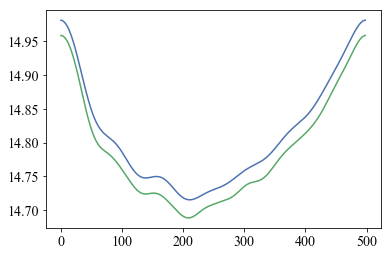

In [951]:
find_period_check_minimum(150, True, True, typee='RRab', phase_range=[0.35,0.65], show_plot=False)
plt.figure()
find_period_check_minimum(150, False, False, typee='RRab', phase_range=[0.35,0.65], show_plot=True)

(4.075634710529865, array([8.1523558]), False)

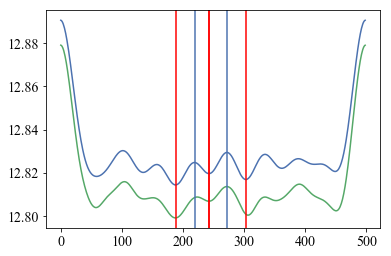

In [952]:
find_period_check_minimum(0, True, True, typee='EA/EB', phase_range=[0.35,0.65], show_plot=False)
plt.figure()
find_period_check_minimum(0, False, False, typee='EA/EB', phase_range=[0.35,0.65], show_plot=True)

In [396]:
XX = np.linspace(0.,10.,11)
n = (len(XX) - 1)
print((np.abs((np.subtract.outer(XX, np.array([3.])) + n//2)%(n) - n//2)).flatten())

[3. 2. 1. 0. 1. 2. 3. 4. 5. 4. 3.]


In [1874]:
def optimum_regularization(ss):
    
    p5_p95 = np.diff(np.nanpercentile(ss['mag'].values,[5.,95.]))[0]
    noise = np.nanmean(ss['error'].values)
    
    N = len(ss)
    
    return np.min([0.25, 2./(p5_p95/noise)**3/(N/100)])

In [1986]:
def optimum_smoothing(ss, plot=False):
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=optimum_regularization(ss))
    if plot:
        plot_lc_LSQ(ss,lsc,fold=True)
#     plt.figure()
    reg_grid = np.logspace(-5,0,50)
    GCVS_r = np.zeros_like(reg_grid)
    for ii,rr in enumerate(reg_grid):
        lsc_t=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
        #                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                         1./lsc['lsq_period'],1.00001/lsc['lsq_period'],
                                                         4,4,4,#lsc['lsq_nterms'],lsc['lsq_nterms'],
                                                         regularization=rr,
                                                         use_nfft=False,regularize_by_trace=True, regularization_power=2.,
                                                         keep_small=True,
                                                         check_multiples=False
                                                        )
        GCVS_r[ii]=GCVS(ss, lsc_t)
        
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=reg_grid[np.argmin(GCVS_r)])
    if plot:
        plot_lc_LSQ(ss,lsc,fold=True)
    mean = np.nanmean(ss['mag'].values/ss['error'].values**2)/ np.nanmean(1./ss['error'].values**2)
    std = np.sqrt(np.nanmean((ss['mag'].values-mean)**2/ss['error'].values**2)/ np.nanmean(1./ss['error'].values**2))
    return reg_grid[np.argmin(GCVS_r)], len(ss), \
            np.diff(np.nanpercentile(ss['mag'].values, [5.,95.]))[0],\
            np.nanmean(ss['error'].values), std,\
             optimum_regularization(ss)

In [1866]:
def use_opt_smooth(ii):
    
    sid,period,cat_period=v[['sourceid']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],\
                v[['ls_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],\
                v[['cat_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii]
    import sqlutilpy as sqlutil
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<13.)&(ss['amb']==0)].reset_index(drop=True)
    
    snr = np.diff(np.nanpercentile(ss['mag'].values,[5.,95.]))[0]/np.nanmean(ss['error'].values)

    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.01,10.,500000,
                                                     1,1,regularization=1e-5)
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,4,10,regularization=optimum_regularization(ss),
                                                     check_multiples=False)
    plot_lc_LSQ(ss, lsc, fold=True)

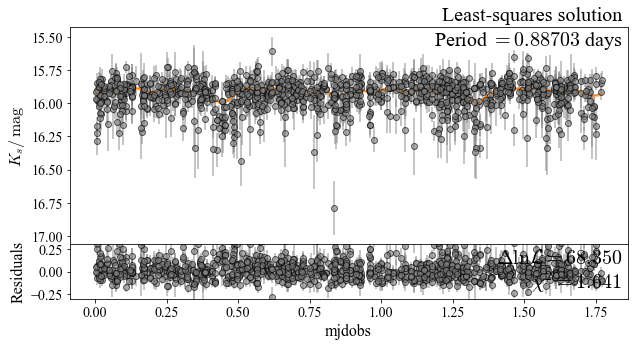

In [1990]:
use_opt_smooth(52)

In [1987]:
def find_opt_ii(ii, with_plot=False, n_det_cut=[0,10000000]):
    fltr = (v['var_class']=='EA/EB')&(v['ks_n_detections']>n_det_cut[0])&(v['ks_n_detections']<n_det_cut[1])
    sid,period,cat_period=v[['sourceid']][fltr].values[ii],\
                v[['ls_period']][fltr].values[ii],\
                v[['cat_period']][fltr].values[ii]
    import sqlutilpy as sqlutil
    ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as arc,
                                    unnest(ambiguous_match) as amb,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
    ss = ss[(ss['mag']>0.)&(ss['arc']<13.)&(ss['amb']==0)].reset_index(drop=True)
    return optimum_smoothing(ss, plot=with_plot)

from multiprocessing import Pool

p = Pool(32)
opt_results = np.vstack([np.array([p.map(partial(find_opt_ii, n_det_cut=[0,50]), np.arange(400))])[0],
                         np.array([p.map(partial(find_opt_ii, n_det_cut=[100,1000]), np.arange(400))])[0],
                         np.array([p.map(partial(find_opt_ii, n_det_cut=[1000,3000]), np.arange(400))])[0]])
p.close()
p.join()

../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../../variability/lc_utils.py:741: RuntimeWarning: covariance is not positive-semidefinite.
  size=300)
../../../.

(0.09540954763499944,
 1139,
 5.2535223726000755,
 1.2715856,
 0.0012110289169344236)

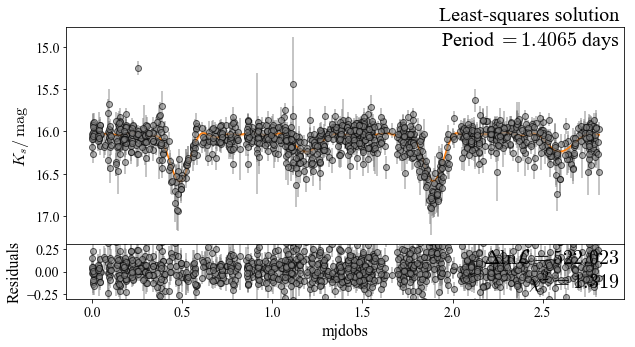

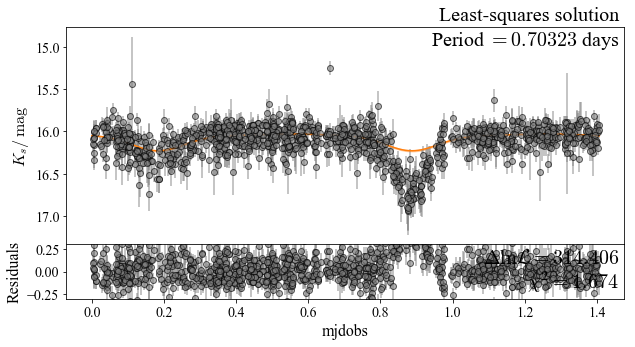

In [1844]:
find_opt_ii(150, True)

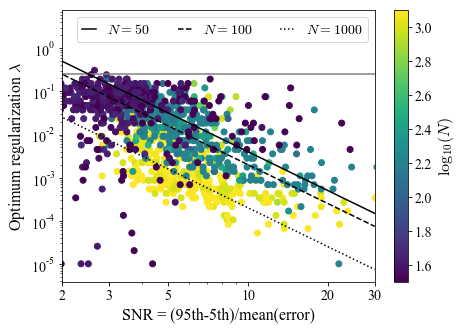

In [1988]:
from matplotlib.ticker import LogLocator, ScalarFormatter
plt.figure(figsize=[7.,5.])
plt.scatter(np.array(opt_results)[::-1,2]/np.array(opt_results)[::-1,3],
            np.array(opt_results)[::-1,0],c=np.log10(np.array(opt_results)[::-1,1]),vmax=3.1,vmin=1.5)
plt.axhline(0.25,color='gray')
xx = np.linspace(1.,30)
plt.plot(xx,2./xx**3/(50/100),color='k',label=r'$N=50$')
plt.plot(xx,2./xx**3,color='k',label=r'$N=100$',ls='dashed')
plt.plot(xx,2./xx**3/(1000/100),color='k',label=r'$N=1000$',ls='dotted')
plt.semilogy()
plt.semilogx()
plt.xlim(2,30)
plt.gca().xaxis.set_major_locator(LogLocator(subs=(0.5,1.,2.,3.)))
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('SNR = (95th-5th)/mean(error)')
plt.ylabel('Optimum regularization $\lambda$')
cax=plt.colorbar(label='$\log_{10}(N)$')
plt.legend(ncol=3,handlelength=1)
plt.savefig('optimal_regularization_4terms.pdf', bbox_inches='tight')

In [1982]:
!pwd

/home/jls/work/data/gaiadr2/virac/variability/thomas/virac_classifier/test_notebooks


[]

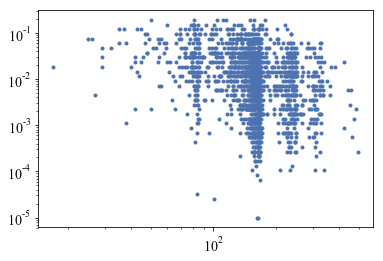

In [1632]:
plt.plot(np.array(opt_results)[:,1],np.array(opt_results)[:,0],'.')
plt.semilogy()
plt.semilogx()

Text(0, 0.5, 'Optimum regularization')

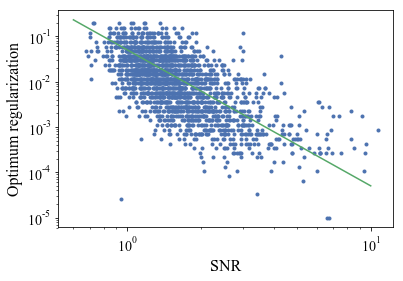

In [1630]:
plt.plot(np.array(opt_results)[:,3],np.array(opt_results)[:,0],'.')
xx = np.linspace(0.6,10.)
plt.plot(xx,.05/xx**3)
plt.semilogy()
plt.semilogx()
plt.xlabel('SNR')
plt.ylabel('Optimum regularization')
# plt.colorbar(label='log10(N)')

[]

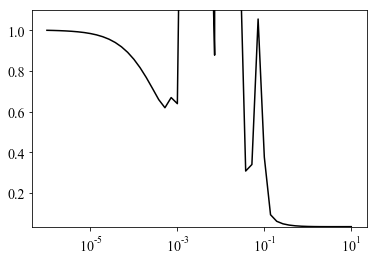

In [1378]:
arr=np.arange(len(ss))
np.random.shuffle(arr)
size = 20
times,mag,err=ss['mjdobs'].values[arr[:size]],ss['mag'].values[arr[:size]],ss['error'].values[arr[:size]]
tm_sort = np.argsort(times)
times, mag, err = times[tm_sort], mag[tm_sort], err[tm_sort]

lsc=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,0.01,10.,500000,
                                                 1,1,regularization=1e-1)
lsc=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,
#                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                 0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                 2,4,10,regularization=1e-1,
                                                 use_nfft=False,regularize_by_trace=True, regularization_power=2.
#                                                  check_multiples=False
                                                )

reg_grid = np.logspace(-6,1,50)
GCVS_r = np.zeros_like(reg_grid)
for ii,rr in enumerate(reg_grid):
    lsc_t=fourier_poly_chi2_fit_full_nterms_iterations(times,mag,err,
    #                                                  1./cat_period[0],1./cat_period[0]*1.0001,
                                                     1./lsc['lsq_period'],1.00001/lsc['lsq_period'],
                                                     2,lsc['lsq_nterms'],lsc['lsq_nterms'],regularization=rr,
                                                     use_nfft=False,regularize_by_trace=True, regularization_power=2.,
                                                     keep_small=True
    #                                                  check_multiples=False
                                                    )
    GCVS_r[ii]=GCVS(ss, lsc_t)
plt.plot(reg_grid, GCVS_r/GCVS_r[0], 'k')
plt.ylim(np.min(GCVS_r/GCVS_r[0])*0.9,1.1)
# plt.semilogy()
plt.semilogx()

/data/jls/python3.5/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


[]

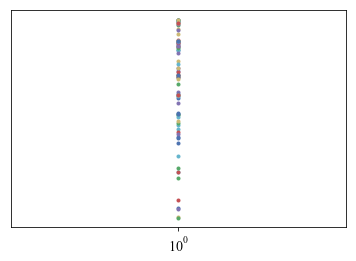

In [1279]:
X = get_X_matrix(ss['mjdobs'].values, lsc)
icov = np.diag(ss['error'].values**2)
plt.plot(icov,np.diag(get_H_matrix(ss, lsc)),'.')
plt.semilogy()
plt.semilogx()

In [1184]:
%%timeit -n 1 -r 1
np.linalg.inv(lsc['fourier_coeffs_cov'])

93.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


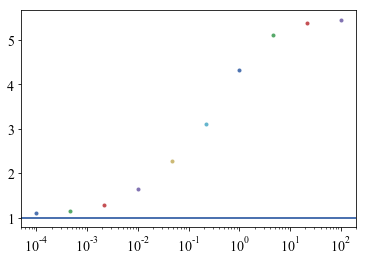

In [1266]:
for rr in np.logspace(-4,2,10):
    lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
                                                     0.5/lsc['lsq_period'],1./lsc['lsq_period'],
                                                     4,10,10,regularization=rr,
                                                     use_nfft=False,regularize_by_trace=True, regularization_power=2.)
    plt.plot(rr,lsc['lsq_chi_squared']/len(ss),'.')
    plt.semilogx()
    plt.axhline(1.)

In [ ]:
chi2 = (y-Mx)**2/sigma**2 + lmbda**2 * M**2

[]

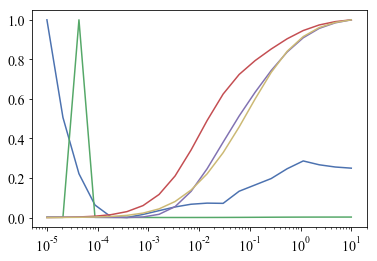

In [944]:
nfolds=5
test_period = lsc['lsq_period']
for test_size in [25,50,100,500,1000]:
    indxr = np.arange(len(ss))
    np.random.shuffle(indxr)
    
    indxr = indxr[:test_size]
    indx = np.arange(len(indxr))
    np.random.shuffle(indx)
    
    reg_grid = np.logspace(-5,1.,20)
    results_cv = np.zeros_like(reg_grid)
    for j,rr in enumerate(reg_grid):
        mm=0
        for ii in range(nfolds):
            indxt=indx[ii*len(indx)//nfolds:(ii+1)*len(indx)//nfolds]
            indxs=list(set(indx)-set(indxt))
            times,mag,err=ss['mjdobs'].values[indxr][indxs],ss['mag'].values[indxr][indxs],ss['error'].values[indxr][indxs]
            tsort = np.argsort(times)
            lsc_test=fourier_poly_chi2_fit_full_nterms_iterations(times[tsort],mag[tsort],err[tsort],
                                                             1./test_period, 1.001/test_period,
                                                             4,10,10,regularization=rr,
                                                             use_nfft=False,
                                                             check_multiples=False
                                                            )
            mm+=np.sum((retrieve_fourier_poly(ss['mjdobs'].values[indxr][indxt],lsc_test)-ss['mag'].values[indxr][indxt])/ss['error'].values[indxr][indxt])**2
        results_cv[j]=mm/nfolds
    plt.plot(reg_grid, (results_cv-np.min(results_cv))/(np.max(results_cv)-np.min(results_cv)))
plt.semilogx()

[0.41302154]
0.91351205
1.0


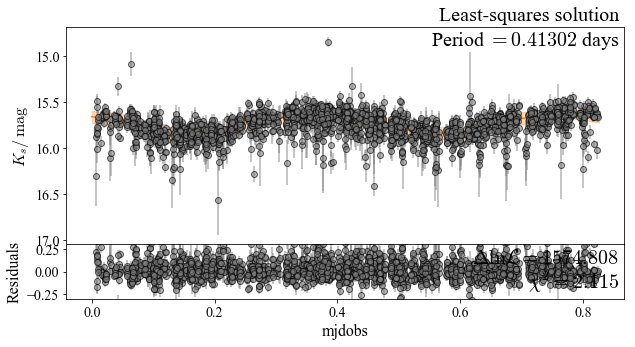

<Figure size 432x288 with 0 Axes>

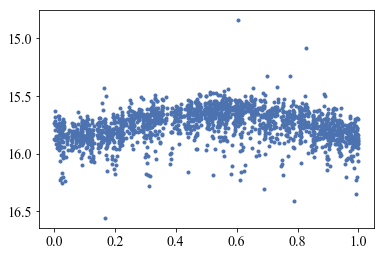

In [1484]:
ii=21
sid,period=v[['sourceid']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii],v[['ls_period']][(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)].values[ii]
import sqlutilpy as sqlutil
ss = pd.DataFrame(sqlutil.get('''select unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train where sourceid=%i;'''%sid,**config.wsdb_kwargs))
print(period)
import sys
sys.path.append('../../../../variability/')
from lc_utils import fourier_poly_chi2_fit_full_nterms_iterations, plot_lc_LSQ
lsc=fourier_poly_chi2_fit_full_nterms_iterations(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,0.01,5.,50000,
                                                 4,4,regularization=1e-4)

plot_lc_LSQ(ss, lsc, fold=True);
t = time.time()
plt.figure()
print(find_peak_ratio(ss, lsc, bin_size=0.05))
print(find_peak_ratio_model(ss, lsc))

# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# lsc=fourier_poly_chi2_fit_full(ss['mjdobs'].values,ss['mag'].values,ss['error'].values,
#                                .5/lsc['lsq_period'],.501/lsc['lsq_period'],2,
#                                3,regularization=1e-4,check_multiples=False)
# print(lsc['lsq_period'])
# print('nterms', lsc['lsq_nterms'])
# print(lsc['lsq_period'])
# print(lsc['amplitudes'])
# plot_lc_LSQ(ss, lsc, fold=True);
# print(find_peak_ratio(ss, lsc, bin_size=0.05))
# print(find_peak_ratio_model(ss, lsc))
# # ss2 = ss.copy()
# # ss2['mjdobs']+=lsc['phases'][0]*lsc['lsq_period']/(2.*np.pi)
# # lsc2=fourier_poly_chi2_fit_full_quick(ss2,nterms=4,minp=0.1,maxp=10.)
# # plot_lc_LSQ(ss2, lsc2, fold=True);
# # print(lsc['amplitudes'])
# # print(lsc2['fourier_coeffs'])

plt.figure()
from lc_utils import find_peak_ratio
plt.plot(((ss['mjdobs']-0.13514197587305296) / ( lsc['lsq_period'] ))% 1, 
         ss['mag'], '.')
plt.gca().invert_yaxis()

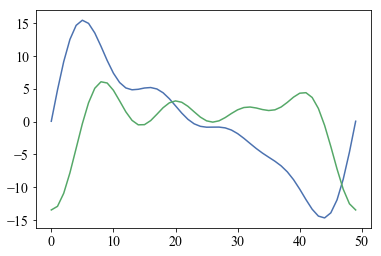

In [1470]:
from lc_utils import find_phase_of_minimum, retrieve_fourier_poly_firstderiv
min_phase = find_phase_of_minimum(ss,lsc)
plt.plot(retrieve_fourier_poly_firstderiv(np.ones(1)*(lsc['lsq_period'] * np.linspace(0.,1.) + min_phase), 
                                                                   lsc))

plt.plot(retrieve_fourier_poly_secondderiv(np.ones(1)*(lsc['lsq_period'] * np.linspace(0.,1.) + min_phase), 
                                                                   lsc)/100.)

In [ ]:
0.04644006 0.16473756 0.04156127 0.10164426

0.16230336 0.10178487 0.07449638 0.05780884

0.21794883 0.05455292 0.01340917 0.00190123
0.00295234 0.21795462 0.00276535 0.05215808

0.11610193 0.03603995 0.02605496 0.00870762
0.00220129 0.11569819 0.00416072 0.03255126

(-0.35, 0.35)

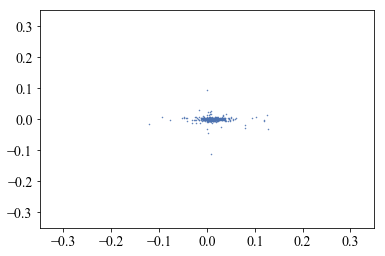

In [165]:

plt.plot((v['amp_1']*np.sin(v['phi_1'])/np.sin(2*v['phi_0']))[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],
         (v['amp_3']*np.sin(v['phi_3'])/np.sin(4*v['phi_0']))[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.plot((v['amp_1'])[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],
#          (v['amp_3'])[(v['var_class']=='EW')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.xlim(-5,5);plt.ylim(-5,5)
plt.xlim(-0.35,0.35)
plt.ylim(-0.35,0.35)

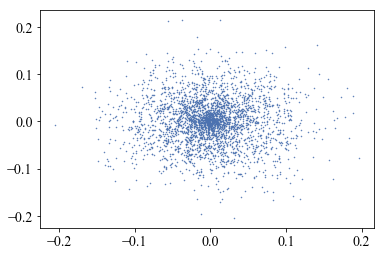

In [130]:

plt.plot((v['amp_0']*np.cos(v['phi_0']))[(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)],
         (v['amp_0']*np.sin(v['phi_0']))[(v['var_class']=='EA/EB')&(v['ks_n_detections']>1000)],'.',ms=1);
# plt.plot(v['lsq_period'][(v['var_class']=='EW')&(v['ks_n_detections']>100)],
#          1./v['a1_a3'][(v['var_class']=='EW')&(v['ks_n_detections']>100)],'.',ms=1);
# plt.semilogy()
# plt.semilogx()
# plt.xlim(0.05,10.)
# plt.ylim(0.,1.)

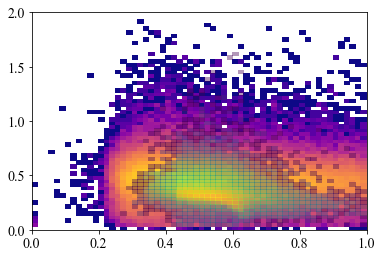

In [164]:
plt.hist2d(v['cat_period'][v['var_class']=='EA/EB'],
           v['ks_p95_p5'][v['var_class']=='EA/EB'],bins=60,range=[[0.,1.],[0.0,2.]],norm=LogNorm(),cmap=plt.cm.plasma);

plt.hist2d(v['cat_period'][v['var_class']=='RRab'],
           v['ks_p95_p5'][v['var_class']=='RRab'],bins=60,range=[[0.,1.],[0.0,2.]],norm=LogNorm(),alpha=0.4);


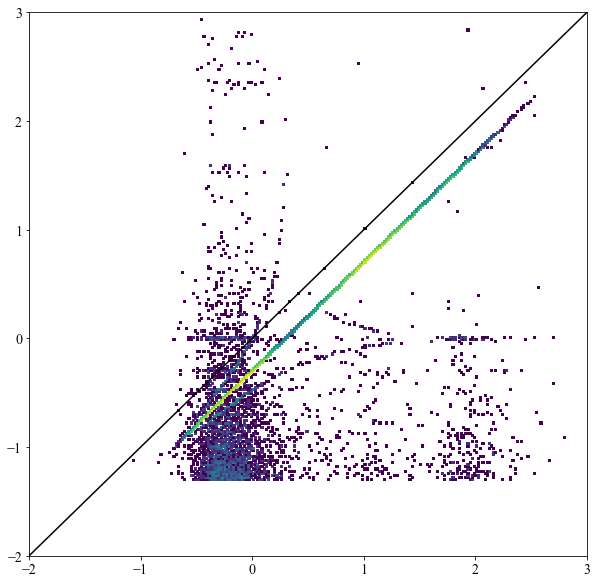

In [49]:

plt.figure(figsize=[10.,10.])
plt.hist2d(np.log10(v['cat_period'][v['var_class']=='Ell']),
           np.log10(v['ls_period'][v['var_class']=='Ell']),bins=260,range=[[-2.,3.],[-2.,3.]],norm=LogNorm());
xx = np.linspace(0.01,1000.)
plt.plot(np.log10(xx),np.log10(xx),color='k')